<a href="https://colab.research.google.com/github/Pengyu-gis/STAT718_Notes/blob/main/718_almost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib-map-utils

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
# Excel file: grid and death sheets
grid = pd.read_excel("/content/drive/MyDrive/stat718/df.xlsx", sheet_name='grid')
death = pd.read_excel("/content/drive/MyDrive/stat718/df.xlsx", sheet_name='death')

# Shapefile: road network
road = gpd.read_file("/content/drive/MyDrive/stat718/TrafficLines2023.shp")  # Ensure files are uploaded to Colab


Preprocess: add labels and weights

In [3]:
death['death'] = 1
death['w'] = 1
grid['death'] = 0


Drop missing AADT and convert AADT to numeric

In [4]:
grid = grid[grid['AADT'].notna()]
death = death[death['AADT'].notna()]
grid['AADT'] = pd.to_numeric(grid['AADT'])
death['AADT'] = pd.to_numeric(death['AADT'])


<ipython-input-4-802cc9575d06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid['AADT'] = pd.to_numeric(grid['AADT'])
<ipython-input-4-802cc9575d06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death['AADT'] = pd.to_numeric(death['AADT'])


Compute total road length (convert to numeric km units)

In [5]:
# Ensure projected CRS in meters
road = road.to_crs(epsg=32133)  # NAD83 / South Carolina (EPSG:32133)
A = road.length.sum() / 10000  # sum in meters, then convert to km * 100


Sample 10,000 background points from grid

In [6]:
np.random.seed(402)
init_sample = grid.sample(n=10000).copy()
init_sample['w'] = A / len(init_sample)


Combine death and sample into one DataFrame

In [7]:
init_comb = pd.concat([death, init_sample], ignore_index=True)


Fit Poisson model (GLM)

In [8]:
# Define predictors and response
X_cols = ['Slope', 'Curvature', 'Night', 'Surface', 'Workzone', 'AADT']
X = init_comb[X_cols]
X = sm.add_constant(X)
y = init_comb['death']
weights = init_comb['w']

poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=weights)
result = poisson_model.fit()
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:                14066
Model:                            GLM   Df Residuals:                    14059
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6560.8
Date:                Mon, 14 Apr 2025   Deviance:                       4989.6
Time:                        20:37:32   Pearson chi2:                 3.89e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03419
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7264      0.046    -15.728      0.0

In [9]:
lambda_hat = result.predict(X)
s = np.std(lambda_hat[init_comb['death'] == 0])
print("Std of lambda_hat (non-event):", s)

A_val = A  # total length in 100m units
n_quad_required = int((A_val**2) * s**2)
print("Estimated quadrature points needed:", n_quad_required)


Std of lambda_hat (non-event): 0.1599357577005596
Estimated quadrature points needed: 391027


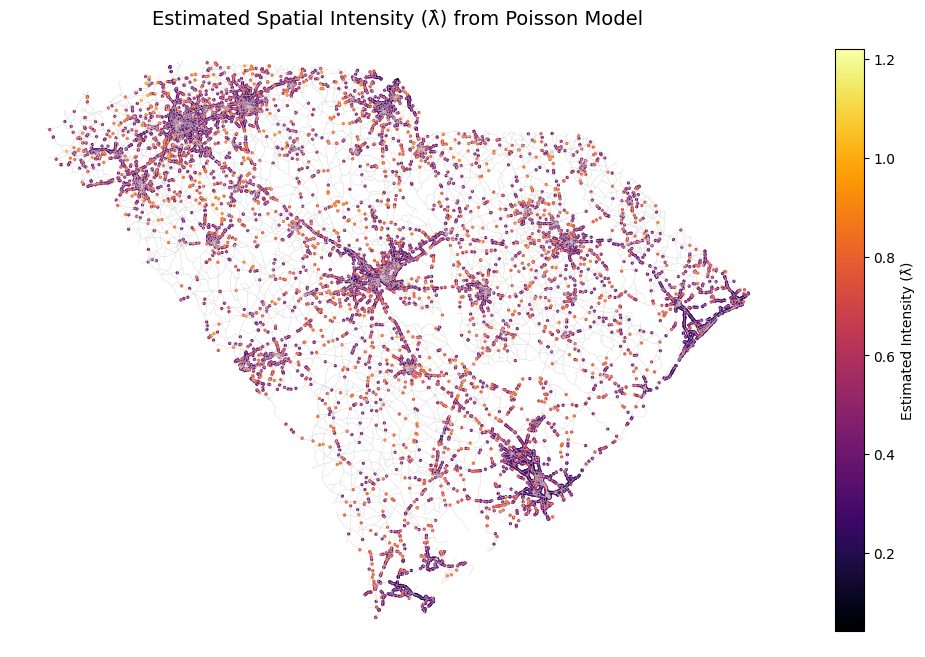

In [10]:
init_comb['lambda_hat'] = lambda_hat
from shapely.geometry import Point

# Construct geometry from X/Y
geometry = [Point(xy) for xy in zip(init_comb['X'], init_comb['Y'])]
gdf_lambda = gpd.GeoDataFrame(init_comb, geometry=geometry)

# Assign proper CRS (you used NAD83 / SC, EPSG:32133)
gdf_lambda.set_crs(epsg=32133, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot with lambda_hat as color
gdf_lambda.plot(ax=ax, column='lambda_hat',
                cmap='inferno',  # or 'viridis', 'plasma'
                markersize=2,
                legend=True,
                legend_kwds={'label': "Estimated Intensity (λ̂)",
                             'shrink': 0.6})

# Optionally overlay road network
road.plot(ax=ax, color='lightgrey', linewidth=0.3)

# Format
ax.set_title("Estimated Spatial Intensity (λ̂) from Poisson Model", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


full-weighted Poisson point process regression with 400,000 quadrature points and optional comparison with a binomial model

In [11]:
quad = grid.sample(n=400000).copy()
quad['w'] = A / len(quad)
quad['death'] = 0


In [12]:
data_comb = pd.concat([death, quad], ignore_index=True)


In [16]:
data_comb.head()

,OBJECTID,x,y,X,Y,Slope,Night,Surface,Workzone,AADT1,AADT,Curvature,Road,death,w,lambda_hat
0,638,-81.49356,34.56973,564313.165949,303572.766908,5.673839,0,1,0,16300,2300.0,5000.000000,highway,1,1.0,0.455549
1,712,-80.95755,34.89223,613480.339951,339240.978221,3.977372,0,0,0,3000,5800.0,4471.270872,local,1,1.0,0.447286
2,720,-79.87691,34.14411,713161.021469,256820.041696,2.623808,0,0,0,5200,950.0,2032.936852,highway,1,1.0,0.479509
3,954,-81.07091,33.92795,603044.755942,232286.899964,1.088653,0,0,0,4400,1200.0,5000.000000,highway,1,1.0,0.446843
4,1258,-81.40931,34.19725,571879.897023,262225.615175,3.412245,0,0,0,8100,4600.0,5000.000000,highway,1,1.0,0.446669


In [13]:
X_cols = ['Slope', 'Curvature', 'Night', 'Surface', 'Workzone', 'AADT']
X = data_comb[X_cols]
X = sm.add_constant(X)
y = data_comb['death']
weights = data_comb['w']

poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=weights)
poisson_result = poisson_model.fit()
print(poisson_result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:               404066
Model:                            GLM   Df Residuals:                   404059
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6564.2
Date:                Mon, 14 Apr 2025   Deviance:                       4996.4
Time:                        20:46:06   Pearson chi2:                 3.89e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001194
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7487      0.046    -16.249      0.0

In [14]:
binomial_model = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=weights)
binomial_result = binomial_model.fit()
print(binomial_result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:               404066
Model:                            GLM   Df Residuals:                   404059
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5018.9
Date:                Mon, 14 Apr 2025   Deviance:                       10038.
Time:                        20:47:19   Pearson chi2:                 8.15e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002511
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0541      0.069     -0.780      0.4

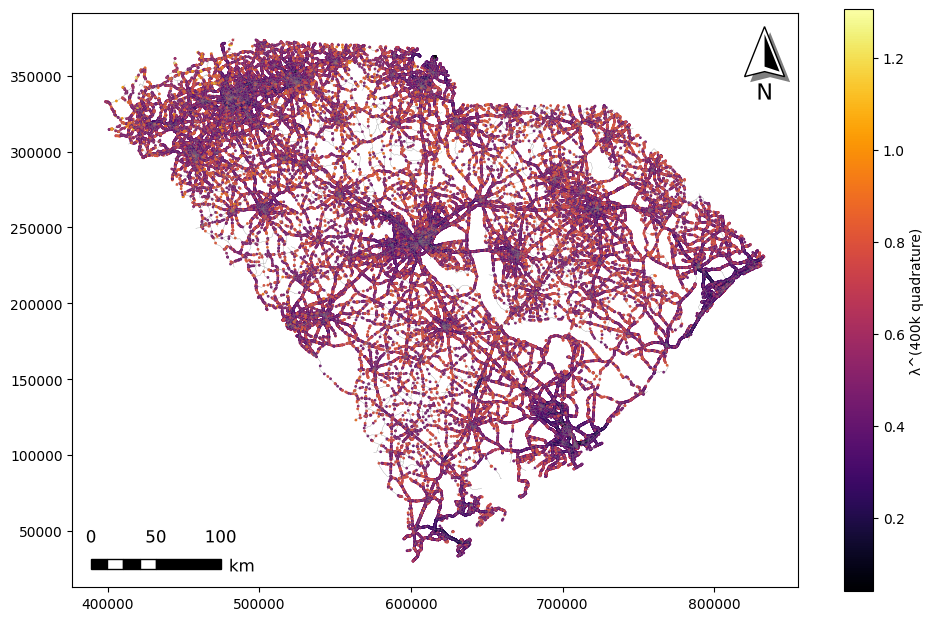

In [149]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_map_utils.core.scale_bar import scale_bar

# Create GeoDataFrame with predicted lambda values
data_comb['lambda_hat'] = poisson_result.predict(sm.add_constant(data_comb[X_cols]))
geometry = [Point(xy) for xy in zip(data_comb['X'], data_comb['Y'])]
gdf_lambda_full = gpd.GeoDataFrame(data_comb, geometry=geometry)
gdf_lambda_full.set_crs(epsg=32133, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_lambda_full.plot(
    ax=ax, column='lambda_hat', cmap='inferno', markersize=1,
    legend=True, legend_kwds={'label': "λ^(400k quadrature)", 'shrink': 0.6}
)
road.plot(ax=ax, color='gray', linewidth=0.2)
# Add north arrow
north_arrow(
    ax,
    location="upper right",
    rotation={"crs": gdf_lambda_full.crs, "reference": "center"}
)

# Add scale bar
scale_bar(
    ax,
    location="lower left",
    style="boxes",
    bar={"projection": gdf_lambda_full.crs, "unit": "km", "max": 100, "major_div": 2,
        "minor_div": 4}
)

ax.set_axis_on()
plt.tight_layout()
plt.show()


Negative Binomial (NB) regression

In [17]:
from statsmodels.genmod.families import NegativeBinomial
X = data_comb[X_cols]
X = sm.add_constant(X)
y = data_comb['death']
weights = data_comb['w']

nb_model = sm.GLM(y, X, family=NegativeBinomial(alpha=1.0), var_weights=weights)
nb_result = nb_model.fit()
print(nb_result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:               404066
Model:                            GLM   Df Residuals:                   404059
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7536.5
Date:                Mon, 14 Apr 2025   Deviance:                       3799.7
Time:                        21:01:39   Pearson chi2:                 2.72e+03
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0008106
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7560      0.057    -13.247      0.0

In [20]:
poisson_deviance = poisson_result.deviance
poisson_df = poisson_result.df_resid
dispersion_ratio = poisson_deviance / poisson_df
print("Dispersion:", dispersion_ratio)


Dispersion: 0.012365474960361183


### effect of AADT

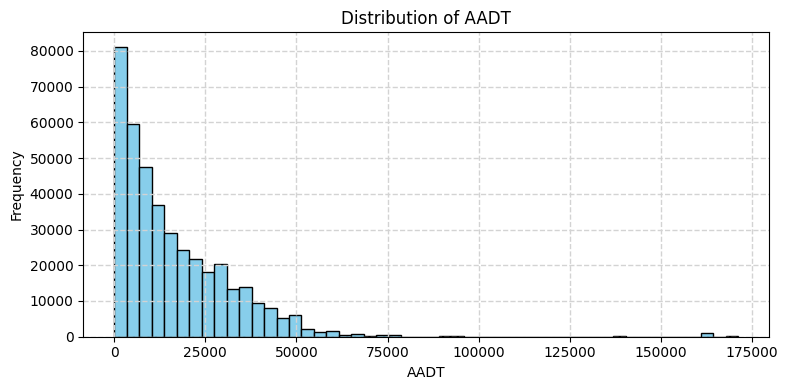

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(data_comb['AADT'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of AADT')
plt.xlabel('AADT')
plt.ylabel('Frequency')
plt.grid(which='major', linestyle='--', color='lightgray', linewidth=1)
plt.tight_layout()
plt.show()


 Step 2: Sort data by AADT and truncate bottom 400,000 for robustness test

In [22]:
data_sorted = data_comb.sort_values(by='AADT')
df = data_sorted.iloc[:400000].copy()


In [23]:
X = sm.add_constant(df[X_cols])
y = df['death']
w = df['w']

model_filtered = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=w).fit()
print(model_filtered.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:               400000
Model:                            GLM   Df Residuals:                   399993
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6522.0
Date:                Mon, 14 Apr 2025   Deviance:                       4950.0
Time:                        21:05:28   Pearson chi2:                 3.83e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001203
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7368      0.046    -15.884      0.0

**Sliding window analysis**

In [24]:
window_size = 200000
step = 5000
coefficients = []

for start in range(0, len(df) - window_size + 1, step):
    window_df = df.iloc[start:start + window_size]
    X_win = sm.add_constant(window_df[X_cols])
    y_win = window_df['death']
    w_win = window_df['w']

    model = sm.GLM(y_win, X_win, family=sm.families.Poisson(), var_weights=w_win).fit()
    coef_AADT = model.params['AADT']
    coefficients.append(coef_AADT)


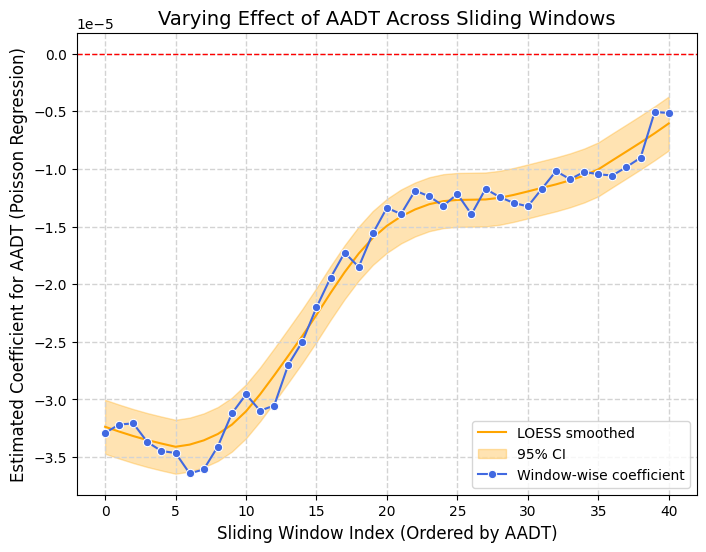

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

# Example data
aadts = pd.DataFrame({
    'index': range(len(coefficients)),
    'AADT_coef': coefficients
})

# Compute LOESS smoothing
loess_smoothed = lowess(aadts['AADT_coef'], aadts['index'], frac=0.3, return_sorted=False)

# Estimate confidence interval (you may improve this with bootstrapping)
residuals = aadts['AADT_coef'] - loess_smoothed
std_err = residuals.std()
ci = 1.96 * std_err  # approximate 95% CI

# Plot
plt.figure(figsize=(8, 6))

# LOESS line
plt.plot(aadts['index'], loess_smoothed, color='orange', label='LOESS smoothed')

# Error ribbon
plt.fill_between(aadts['index'], loess_smoothed - ci, loess_smoothed + ci,
                 color='orange', alpha=0.3, label='95% CI')

# Window-wise coefficients
sns.lineplot(data=aadts, x='index', y='AADT_coef', marker='o',
             label='Window-wise coefficient', color='royalblue')

# Reference line
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Formatting
plt.title("Varying Effect of AADT Across Sliding Windows", fontsize=14)
plt.xlabel("Sliding Window Index (Ordered by AADT)", fontsize=12)
plt.ylabel("Estimated Coefficient for AADT (Poisson Regression)", fontsize=12)
plt.legend()
plt.grid(which='major', linestyle='--', color='lightgray', linewidth=1)
plt.show()


#### Adapt the sliding window to slope & curvature

In [75]:
# Sort data by Slope
sorted_data = data_comb.sort_values(by='Slope').reset_index(drop=True)

window_size = 200000
step = 5000
slope_coefs = []
curvature_coefs = []

for start in range(0, len(sorted_data) - window_size + 1, step):
    window_df = sorted_data.iloc[start:start + window_size]

    X_win = sm.add_constant(window_df[X_cols])
    y_win = window_df['death']
    w_win = window_df['w']

    model = sm.GLM(y_win, X_win, family=sm.families.Poisson(), var_weights=w_win).fit()

    slope_coefs.append(model.params['Slope'])
    curvature_coefs.append(model.params['Curvature'])


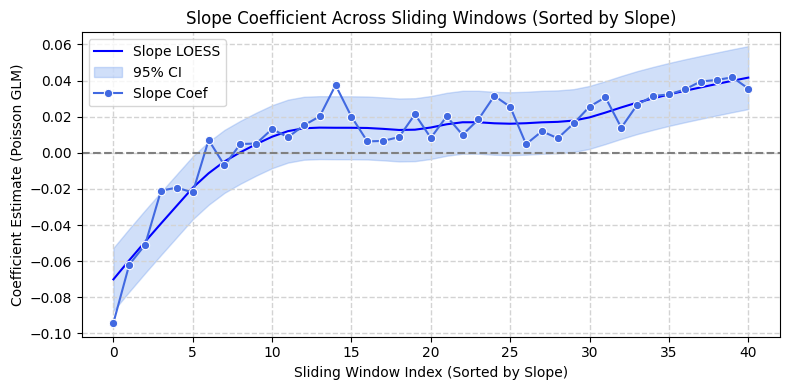

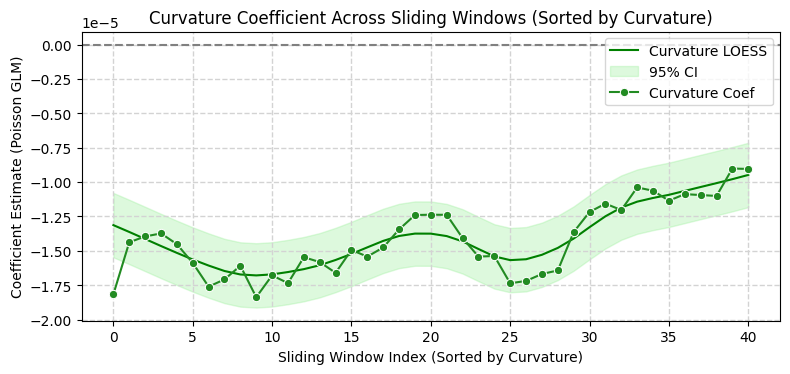

In [94]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# DataFrame already defined
df_coef = pd.DataFrame({
    'index': range(len(slope_coefs)),
    'Slope_coef': slope_coefs,
    'Curvature_coef': curvature_coefs
})

# Slope plot with error ribbon
plt.figure(figsize=(8, 4))
slope_loess = lowess(df_coef['Slope_coef'], df_coef['index'], frac=0.3, return_sorted=False)
slope_resid = df_coef['Slope_coef'] - slope_loess
slope_se = slope_resid.std()
slope_ci = 1.96 * slope_se

plt.plot(df_coef['index'], slope_loess, color='blue', label='Slope LOESS')
plt.fill_between(df_coef['index'], slope_loess - slope_ci, slope_loess + slope_ci,
                 color='cornflowerblue', alpha=0.3, label='95% CI')
sns.lineplot(x='index', y='Slope_coef', data=df_coef, marker='o', color='royalblue', label='Slope Coef')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Slope Coefficient Across Sliding Windows (Sorted by Slope)")
plt.xlabel("Sliding Window Index (Sorted by Slope)")
plt.ylabel("Coefficient Estimate (Poisson GLM)")
plt.legend()
plt.grid(which='major', linestyle='--', color='lightgray', linewidth=1)
plt.tight_layout()
plt.show()

# Curvature plot with error ribbon
plt.figure(figsize=(8, 4))
curv_loess = lowess(df_coef['Curvature_coef'], df_coef['index'], frac=0.3, return_sorted=False)
curv_resid = df_coef['Curvature_coef'] - curv_loess
curv_se = curv_resid.std()
curv_ci = 1.96 * curv_se

plt.plot(df_coef['index'], curv_loess, color='green', label='Curvature LOESS')
plt.fill_between(df_coef['index'], curv_loess - curv_ci, curv_loess + curv_ci,
                 color='lightgreen', alpha=0.3, label='95% CI')
sns.lineplot(x='index', y='Curvature_coef', data=df_coef, marker='o', color='forestgreen', label='Curvature Coef')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Curvature Coefficient Across Sliding Windows (Sorted by Curvature)")
plt.xlabel("Sliding Window Index (Sorted by Curvature)")
plt.ylabel("Coefficient Estimate (Poisson GLM)")
plt.legend()
plt.grid(which='major', linestyle='--', color='lightgray', linewidth=1)
plt.tight_layout()
plt.show()


## Highway & Local Way

#### Highway

In [93]:
# Drop NA
grid_road = grid[grid['Road'].notna()]
death_road = death[death['Road'].notna()]

# Subset for highways
grid_highway = grid_road[grid_road['Road'] == 'highway'].copy()
death_highway = death_road[death_road['Road'] == 'highway'].copy()


In [120]:
road_highway = gpd.read_file("/content/SC_Road_Highway.shp")
road_highway = road_highway.to_crs(epsg=32133)  # South Carolina CRS in meters
A_highway = road_highway.length.sum() / 10000


 Sample 10,000 points from highway background

In [122]:
np.random.seed(42)
init_sample = grid_highway.sample(n=10000).copy()
init_sample['w'] = A_highway / len(init_sample)
init_sample['death'] = 0


Combine with fatality records and fit model

In [123]:
init_comb = pd.concat([death_highway, init_sample], ignore_index=True)

X = sm.add_constant(init_comb[X_cols])
y = init_comb['death']
weights = init_comb['w']

model_highway = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=weights).fit()
print(model_highway.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:                12881
Model:                            GLM   Df Residuals:                    12874
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4081.4
Date:                Mon, 14 Apr 2025   Deviance:                       2400.8
Time:                        22:08:43   Pearson chi2:                 1.65e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01638
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5117      0.059     -8.723      0.0

Calculate λ̂ and SD, then determine quadrature size

In [125]:
lambda_hat = model_highway.predict(X)
s = np.std(lambda_hat[init_comb['death'] == 0])

print("s =", s)
print("A * s / 100 =", A_highway * s / 100)
print("A^2 * s^2 =", A_highway**2 * s**2)


s = 0.15247600909902656
A * s / 100 = 2.521266485702153
A^2 * s^2 = 63567.846919248834


Sample 70,000 quadrature points from grid_highway

In [126]:
quad = grid_highway.sample(n=70000).copy()
quad['w'] = A_highway / len(quad)
quad['death'] = 0


In [127]:
data_highway = pd.concat([death_highway, quad], ignore_index=True)

X_hw = sm.add_constant(data_highway[X_cols])
y_hw = data_highway['death']
w_hw = data_highway['w']

final_model_hw = sm.GLM(y_hw, X_hw, family=sm.families.Poisson(), var_weights=w_hw).fit()
print(final_model_hw.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:                72881
Model:                            GLM   Df Residuals:                    72874
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4082.4
Date:                Mon, 14 Apr 2025   Deviance:                       2402.7
Time:                        22:11:37   Pearson chi2:                 1.64e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.002889
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5305      0.059     -9.047      0.0

#### Local

In [128]:
grid_local = grid[grid['Road'] == 'local'].copy()
death_local = death[death['Road'] == 'local'].copy()
road_local = gpd.read_file("/content/SC_Road_Local.shp")

road_local = road_local.to_crs(epsg=32133)  # Project to meters
A_local = road_local.length.sum() / 10000   # Convert to 100m units

init_sample = grid_local.sample(n=10000).copy()
init_sample['w'] = A_local / len(init_sample)
init_sample['death'] = 0
init_comb = pd.concat([death_local, init_sample], ignore_index=True)

X = sm.add_constant(init_comb[X_cols])
y = init_comb['death']
w = init_comb['w']

model_local = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=w).fit()
print(model_local.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:                11176
Model:                            GLM   Df Residuals:                    11169
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2303.7
Date:                Mon, 14 Apr 2025   Deviance:                       2255.4
Time:                        22:15:32   Pearson chi2:                 2.28e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02333
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9421      0.079    -11.957      0.0

In [129]:
lambda_hat_local = model_local.predict(X)
s_local = np.std(lambda_hat_local[init_comb['death'] == 0])
print("s (local roads) =", s_local)


s (local roads) = 0.15016864344968017


In [130]:
quad_local = grid_local.sample(n=110000).copy()
quad_local['w'] = A_local / len(quad_local)
quad_local['death'] = 0


In [131]:
data_local = pd.concat([death_local, quad_local], ignore_index=True)

X = sm.add_constant(data_local[X_cols])
y = data_local['death']
w = data_local['w']

final_model_local = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=w).fit()
print(final_model_local.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  death   No. Observations:               111176
Model:                            GLM   Df Residuals:                   111169
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2301.6
Date:                Mon, 14 Apr 2025   Deviance:                       2251.2
Time:                        22:15:52   Pearson chi2:                 2.27e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002408
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9337      0.079    -11.825      0.0

#### Plot λ̂(x) for Highway and Local Roads

In [132]:
# For highway
data_highway['lambda_hat'] = final_model_hw.predict(sm.add_constant(data_highway[X_cols]))

# For local
data_local['lambda_hat'] = final_model_local.predict(sm.add_constant(data_local[X_cols]))


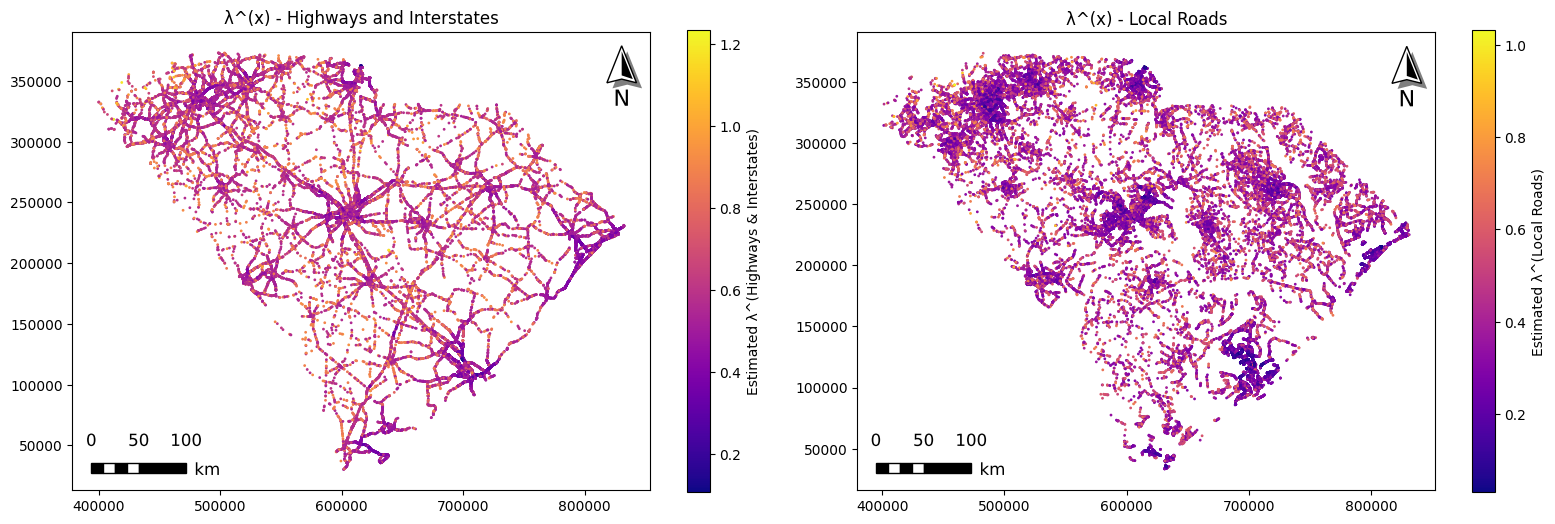

In [151]:
# Prepare GeoDataFrames
geometry_hw = [Point(xy) for xy in zip(data_highway['X'], data_highway['Y'])]
gdf_hw = gpd.GeoDataFrame(data_highway, geometry=geometry_hw, crs="EPSG:32133")

geometry_local = [Point(xy) for xy in zip(data_local['X'], data_local['Y'])]
gdf_local = gpd.GeoDataFrame(data_local, geometry=geometry_local, crs="EPSG:32133")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Highway
gdf_hw.plot(ax=axes[0], column='lambda_hat', cmap='plasma', markersize=1,
            legend=True, legend_kwds={'label': "Estimated λ^(Highways & Interstates)", 'shrink': 0.6})
axes[0].set_title("λ^(x) - Highways and Interstates")
#axes[0].set_axis_off()

# Add north arrow and scale bar to left plot
north_arrow(axes[0], location="upper right", scale=0.37, rotation={"crs": gdf_hw.crs, "reference": "center"})
scale_bar(axes[0], location="lower left", style="boxes", bar={"projection": gdf_hw.crs, "max": 100, "major_div": 2, "minor_div": 4})

# Plot Local Roads
gdf_local.plot(ax=axes[1], column='lambda_hat', cmap='plasma', markersize=1,
               legend=True, legend_kwds={'label': "Estimated λ^(Local Roads)", 'shrink': 0.6})
axes[1].set_title("λ^(x) - Local Roads")
#axes[1].set_axis_off()

# Add north arrow and scale bar to right plot
north_arrow(axes[1], location="upper right",scale=0.37, rotation={"crs": gdf_local.crs, "reference": "center"})
scale_bar(axes[1], location="lower left", style="boxes", bar={"projection": gdf_local.crs, "max": 100, "major_div": 2, "minor_div": 4})


plt.tight_layout()
plt.show()


#### Sliding window of AADT

In [152]:
# Sort by AADT
df_hw = data_highway.sort_values(by='AADT').reset_index(drop=True)
df_local = data_local.sort_values(by='AADT').reset_index(drop=True)


In [153]:
def sliding_window_coefficients(df, window_size, step, predictor='AADT'):
    coefs = []
    indices = []
    for start in range(0, len(df) - window_size + 1, step):
        subset = df.iloc[start:start + window_size]
        X_win = sm.add_constant(subset[X_cols])
        y_win = subset['death']
        w_win = subset['w']
        model = sm.GLM(y_win, X_win, family=sm.families.Poisson(), var_weights=w_win).fit()
        coefs.append(model.params[predictor])
        indices.append(start)
    return pd.DataFrame({'WindowStart': indices, 'Coefficient': coefs})


In [154]:
# Highway: larger step size
aadts_hw = sliding_window_coefficients(df_hw, window_size=20000, step=5000)

# Local: smaller step size
aadts_local = sliding_window_coefficients(df_local, window_size=20000, step=2000)


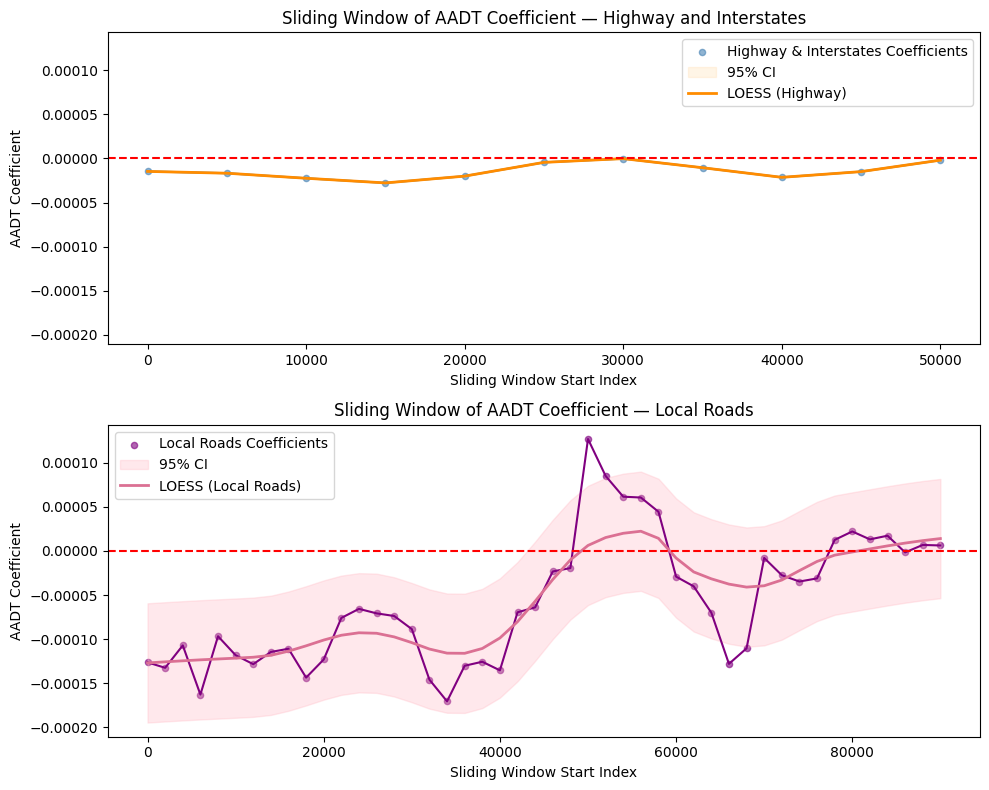

In [191]:
def add_loess_with_ci(ax, x, y, frac=0.3, line_color='black', ci_color='gray', label='LOESS'):
    """Plot LOESS smoothed line with separate color for confidence ribbon."""
    loess_result = lowess(y, x, frac=frac, return_sorted=False)
    residuals = y - loess_result
    ci = 1.96 * np.std(residuals)

    # CI ribbon
    ax.fill_between(x, loess_result - ci, loess_result + ci,
                    color=ci_color, alpha=0.3, label='95% CI')

    # LOESS line
    ax.plot(x, loess_result, color=line_color, linewidth=2, label=label)


# Initialize subplot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# ---------- Highway ----------
x_hw = aadts_hw['WindowStart']
y_hw = aadts_hw['Coefficient']

# Raw coefficient points
axes[0].scatter(x_hw, y_hw, color='steelblue', s=20, label='Highway & Interstates Coefficients', alpha=0.6)

# Line plot (optional, for continuity)
sns.lineplot(x=x_hw, y=y_hw, ax=axes[0], color='steelblue', label='_nolegend_')

# LOESS + CI
add_loess_with_ci(
    axes[0],
    x_hw,
    y_hw,
    line_color='darkorange',
    ci_color='navajowhite',
    label='LOESS (Highway)'
)

# Decorations
axes[0].axhline(0, linestyle='--', color='red')
axes[0].set_title('Sliding Window of AADT Coefficient — Highway and Interstates')
axes[0].set_xlabel('Sliding Window Start Index')
axes[0].set_ylabel('AADT Coefficient')
axes[0].legend()

# ---------- Local ----------
x_local = aadts_local['WindowStart']
y_local = aadts_local['Coefficient']

axes[1].scatter(x_local, y_local, color='purple', s=20, label='Local Roads Coefficients', alpha=0.6)
sns.lineplot(x=x_local, y=y_local, ax=axes[1], color='purple', label='_nolegend_')
add_loess_with_ci(
    axes[1],
    x_local,
    y_local,
    line_color='palevioletred',
    ci_color='lightpink',
    label='LOESS (Local Roads)'
)

axes[1].axhline(0, linestyle='--', color='red')
axes[1].set_title('Sliding Window of AADT Coefficient — Local Roads')
axes[1].set_xlabel('Sliding Window Start Index')
axes[1].set_ylabel('AADT Coefficient')
axes[1].legend()

plt.tight_layout()
plt.show()


#### Sliding Window for Slope and Curvature (Highway)

In [192]:
def sliding_window_coeff(df, predictor, window_size, step):
    coefs = []
    starts = []
    df_sorted = df.sort_values(by=predictor).reset_index(drop=True)
    for start in range(0, len(df_sorted) - window_size + 1, step):
        sub = df_sorted.iloc[start:start + window_size]
        X = sm.add_constant(sub[X_cols])
        y = sub['death']
        w = sub['w']
        try:
            model = sm.GLM(y, X, family=sm.families.Poisson(), var_weights=w).fit()
            coefs.append(model.params[predictor])
        except Exception:
            coefs.append(np.nan)  # fail-safe
        starts.append(start)
    return pd.DataFrame({'WindowStart': starts, 'Coefficient': coefs})


In [ ]:
# Slope - highway
slope_hw = sliding_window_coeff(data_highway, predictor='Slope', window_size=20000, step=5000)

# Curvature - highway
curve_hw = sliding_window_coeff(data_highway, predictor='Curvature', window_size=10000, step=1000)


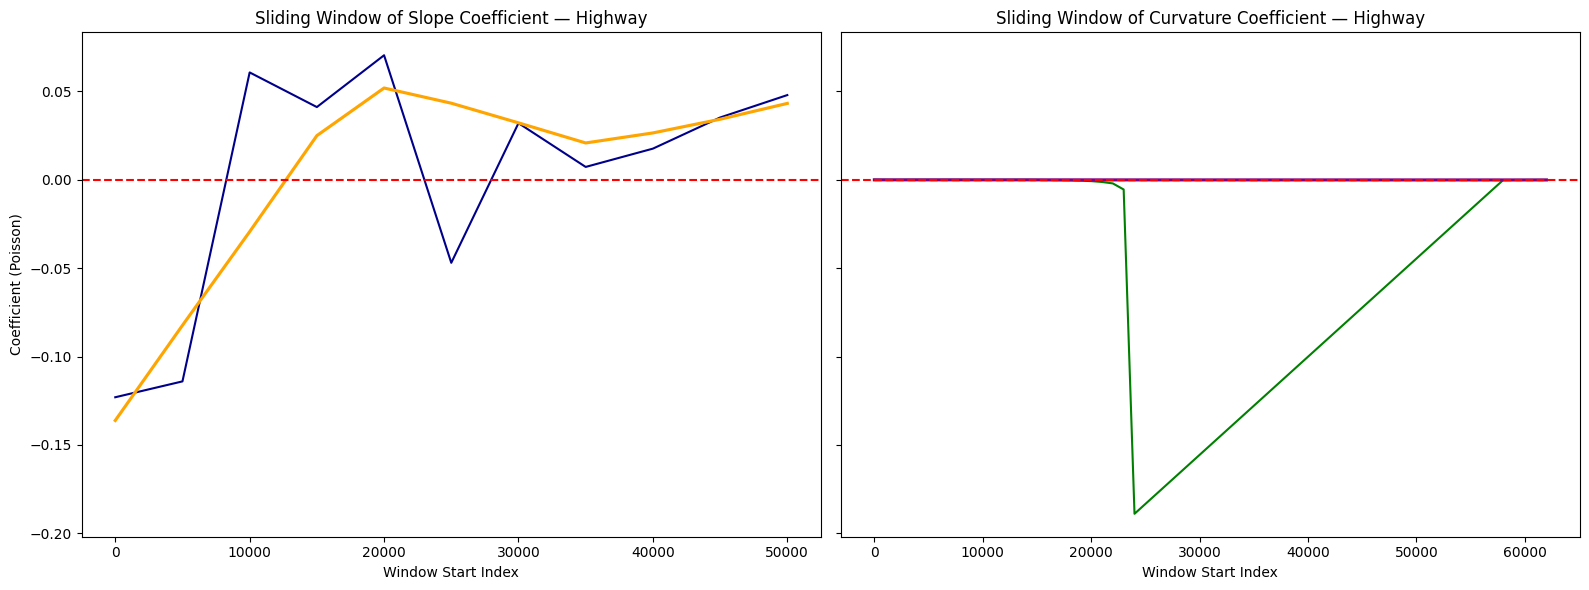

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Slope
sns.lineplot(data=slope_hw, x='WindowStart', y='Coefficient', ax=axes[0], color='darkblue')
sns.regplot(data=slope_hw, x='WindowStart', y='Coefficient', lowess=True, scatter=False, ax=axes[0], color='orange')
axes[0].axhline(0, linestyle='--', color='red')
axes[0].set_title("Sliding Window of Slope Coefficient — Highway")
axes[0].set_xlabel("Window Start Index")
axes[0].set_ylabel("Coefficient (Poisson)")

# Curvature
sns.lineplot(data=curve_hw, x='WindowStart', y='Coefficient', ax=axes[1], color='green')
sns.regplot(data=curve_hw, x='WindowStart', y='Coefficient', lowess=True, scatter=False, ax=axes[1], color='purple')
axes[1].axhline(0, linestyle='--', color='red')
axes[1].set_title("Sliding Window of Curvature Coefficient — Highway")
axes[1].set_xlabel("Window Start Index")

plt.tight_layout()
plt.show()


#### Sliding Window for Slope and Curvature (Local)

In [ ]:
# Slope - local
slope_local = sliding_window_coeff(data_local, predictor='Slope', window_size=20000, step=2000)

# Curvature - local
curve_local = sliding_window_coeff(data_local, predictor='Curvature', window_size=20000, step=2000)


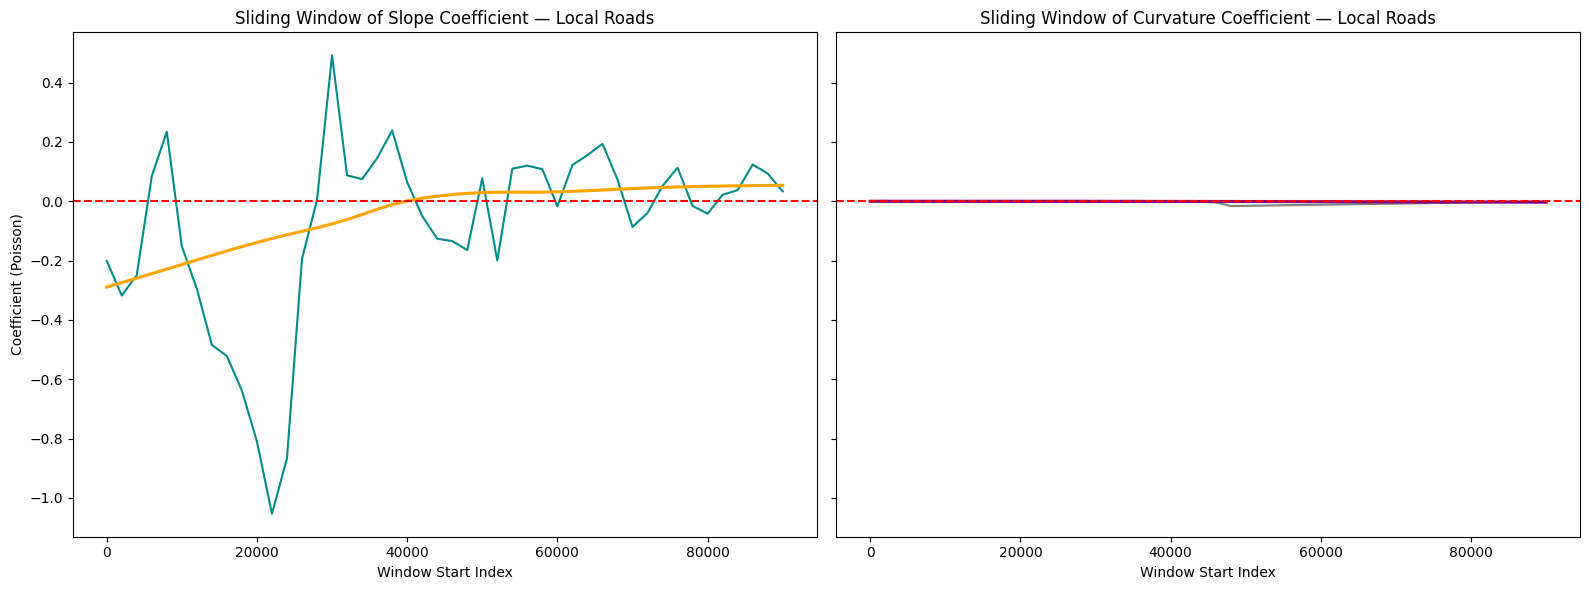

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Slope
sns.lineplot(data=slope_local, x='WindowStart', y='Coefficient', ax=axes[0], color='darkcyan')
sns.regplot(data=slope_local, x='WindowStart', y='Coefficient', lowess=True, scatter=False, ax=axes[0], color='orange')
axes[0].axhline(0, linestyle='--', color='red')
axes[0].set_title("Sliding Window of Slope Coefficient — Local Roads")
axes[0].set_xlabel("Window Start Index")
axes[0].set_ylabel("Coefficient (Poisson)")

# Curvature
sns.lineplot(data=curve_local, x='WindowStart', y='Coefficient', ax=axes[1], color='gray')
sns.regplot(data=curve_local, x='WindowStart', y='Coefficient', lowess=True, scatter=False, ax=axes[1], color='purple')
axes[1].axhline(0, linestyle='--', color='red')
axes[1].set_title("Sliding Window of Curvature Coefficient — Local Roads")
axes[1].set_xlabel("Window Start Index")

plt.tight_layout()
plt.show()
